In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

### Import MIDI data 

In [3]:
num_files_desired = 1000

from importMIDI import ImportMIDI 
importedMIDI = ImportMIDI(num_files = num_files_desired)
imported_data_MIDI = importedMIDI.get_midi_data()

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=100)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=100)]: Done   3 tasks      | elapsed:   11.0s
[Parallel(n_jobs=100)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=100)]: Done   5 tasks      | elapsed:   11.1s
[Parallel(n_jobs=100)]: Done   6 tasks      | elapsed:   11.2s
[Parallel(n_jobs=100)]: Done   7 tasks      | elapsed:   12.5s
[Parallel(n_jobs=100)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=100)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=100)]: Done  10 tasks      | elapsed:   12.7s
[Parallel(n_jobs=100)]: Done  11 tasks      | elapsed:   12.7s
[Parallel(n_jobs=100)]: Done  12 tasks      | elapsed:   12.8s
[Parallel(n_jobs=100)]: Done  13 tasks      | elapsed:   12.9s
[Parallel(n_jobs=100)]: Done  14 tasks      | elapsed:   13.0s
[Parallel(n_jobs=100)]: Done  15 tasks 

### Split MIDI data

In [4]:
num_files = imported_data_MIDI.shape[0]

train_size = 0.60
val_size   = 0.30
test_size  = 0.10

val_index  = math.floor(num_files*train_size)
test_index = math.floor(num_files*(1-test_size))

train_data = imported_data_MIDI.iloc[0:val_index]
val_data   = imported_data_MIDI.iloc[val_index:test_index]
test_data  = imported_data_MIDI.iloc[test_index:]

In [5]:
print(num_files)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

107
(64, 9)
(32, 9)
(11, 9)


### Create dataset 

In [6]:
from dataset import MidiDataset

In [7]:
midi_train_dataset = MidiDataset(data = train_data, data_type = "train")
midi_val_dataset   = MidiDataset(data = val_data,   data_type = "val")
midi_test_dataset  = MidiDataset(data = test_data,  data_type = "test")

In [8]:
print(len(midi_train_dataset))
print(len(midi_val_dataset))
print(len(midi_test_dataset))

22763
10932
40670


In [81]:
trainloader = DataLoader(midi_train_dataset, batch_size=256,
                        shuffle=True, num_workers=4)
valloader   = DataLoader(midi_val_dataset, batch_size=256,
                        shuffle=True, num_workers=4)

In [82]:
test_batch_size = 256
testloader  = DataLoader(midi_test_dataset, batch_size=test_batch_size,
                        shuffle=False, num_workers=4)

In [83]:
print(len(testloader.dataset))

40670


In [208]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        for j in range(num_notes):
            if (labels[i,j] == 1.0):
                num_pos_pred += 1.0
            else: 
                num_neg_pred += 1.0

            if (preds[i,j] == labels[i,j]): 
                if (preds[i,j] == 1.0):
                    num_true_pos_label += 1.0
                else: 
                    num_true_neg_label += 1.0
                correct += 1.0
            else: 
                if (preds[i,j] == 1.0): 
                    num_false_pos_label += 1.0
                else: 
                    num_false_neg_label += 1.0
            total += 1.0
            
    accuracy = correct/total 
    recall = num_true_pos_label / num_pos_pred
    
    print("Correct: ", correct, ", Num pos: ", num_pos_pred)
    
    return accuracy, recall 

### Create network

In [222]:
from models import Net
net = Net().cuda()

In [223]:
import torch.optim as optim
import torch.nn as nn

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([10.0])).cuda()
optimizer = optim.SGD(net.parameters(), lr=1.0, momentum=0.9)

### Train the network

In [ ]:
net = net.double()

train_loss_list = []
val_loss_list   = []

train_accuracy_list = []
val_accuracy_list   = []

train_recall_list = []
val_recall_list   = []

for epoch in range(20):  # loop over the dataset multiple times

    # TRAIN 
    sum_train_loss = 0
    train_labels = np.zeros((len(trainloader.dataset), num_notes))
    train_preds  = np.zeros((len(trainloader.dataset), num_notes))
    idx = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels.double())
        loss.backward()
        optimizer.step()
        
        sum_train_loss += loss.item()
        
        train_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
        train_preds[idx:idx+labels.shape[0], :]  = outputs.cpu().detach().numpy()

    # Get loss 
    avg_train_loss = sum_train_loss / len(trainloader)
    train_loss_list.append(avg_train_loss)
    
    # Get accuracy 
    avg_train_accuracy, avg_train_recall = evaluate_metrics(train_preds, train_labels)
    
    train_accuracy_list.append(avg_train_accuracy)
    train_recall_list.append(avg_train_recall)
    
    # print statistics
    print("Epoch: ", epoch, ", Train Loss: ", avg_train_loss, ", Train accuracy: ", avg_train_accuracy, ", Train recall: ", avg_train_recall)
            
    # VALIDATE
    sum_val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valloader,0):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs.double())
            loss = criterion(outputs, labels.double())

            sum_val_loss += loss.item()

    avg_val_loss = sum_val_loss / len(valloader)
    val_loss_list.append(avg_val_loss)
    
    # print statistics
    print("Epoch: ", epoch, ", Val Loss: ", avg_val_loss)
        

print('Finished Training')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeb5e95cb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeb5e95cb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeb5e95cb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeb5e95cb0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/marion/.conda/envs/ml/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/marion/.conda/envs/ml/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/marion/.conda/envs/ml/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/marion/.conda/envs/ml/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()

labels:  [[  0  36]
 [  1  33]
 [  2  33]
 [  4  42]
 [  4  66]
 [  6  70]
 [  9  36]
 [ 10  43]
 [ 12  32]
 [ 13  38]
 [ 14  42]
 [ 16  31]
 [ 17  38]
 [ 18  42]
 [ 19  38]
 [ 21  39]
 [ 25  43]
 [ 27  37]
 [ 28  38]
 [ 28  62]
 [ 29  43]
 [ 30  45]
 [ 31  33]
 [ 33  35]
 [ 34  38]
 [ 37  33]
 [ 38  29]
 [ 39  59]
 [ 41  36]
 [ 42  37]
 [ 43  36]
 [ 44  44]
 [ 47  39]
 [ 48  35]
 [ 49  33]
 [ 51  33]
 [ 52  36]
 [ 55  45]
 [ 56  31]
 [ 56  67]
 [ 57  34]
 [ 58  36]
 [ 59  31]
 [ 61  38]
 [ 62  47]
 [ 64  27]
 [ 67  38]
 [ 70  39]
 [ 71  38]
 [ 76  45]
 [ 77  36]
 [ 78  35]
 [ 78  38]
 [ 79  28]
 [ 80  40]
 [ 84  37]
 [ 85  40]
 [ 86  32]
 [ 86  44]
 [ 87  36]
 [ 88  31]
 [ 90  41]
 [ 91  33]
 [ 93  33]
 [ 94  62]
 [ 94  66]
 [ 94  69]
 [ 95  38]
 [ 96  38]
 [102  28]
 [102  40]
 [103  37]
 [105  30]
 [106  40]
 [107  36]
 [107  64]
 [109  45]
 [111  27]
 [113  40]
 [114  28]
 [115  33]
 [117  33]
 [118  35]
 [119  36]
 [120  26]
 [120  38]
 [122  40]
 [123  31]
 [125  34]
 [126  38]
 

### Save the network

In [215]:
print(train_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [141]:
PATH = './midi_net.pth'
torch.save(net.state_dict(), PATH)

### Validate the network

In [203]:
PLAYING_THRESH = 0.01

num_notes = 128

val_labels = np.zeros((len(valloader.dataset), num_notes))
val_preds  = np.zeros((len(valloader.dataset), num_notes))

sigmoid = torch.nn.Sigmoid()

with torch.no_grad():
    idx = 0
    for data in valloader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        outputs = net(inputs.double())
        outputs = sigmoid(outputs)

        val_labels[idx:idx+labels.shape[0], :] = labels.cpu().numpy()
        val_preds[idx:idx+labels.shape[0], :]  = outputs.cpu().numpy()
        
        idx = idx + labels.shape[0]
 
import copy
val_preds_probs = copy.deepcopy(val_preds)

val_preds[val_preds <  PLAYING_THRESH] = 0
val_preds[val_preds >= PLAYING_THRESH] = 1

In [204]:
val_preds.shape

(10932, 128)

### Get network metrics

In [206]:
val_accuracy, val_recall = evaluate_metrics(val_preds, val_labels)

In [207]:
print(val_accuracy)
print(val_recall)

0.9503657553512623
0.41556122448979593


### PLOTS

In [147]:
def plot_data(x, y): 
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, marker='_')
    plt.xlabel('Time (x0.01 s)')
    plt.ylabel('MIDI Pitch')
#     plt.ylim(top=384)
    plt.show()

### Loss

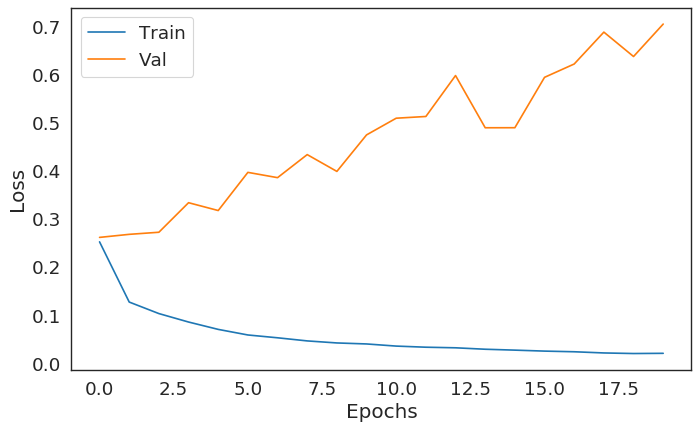

In [192]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list,   label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Val data 

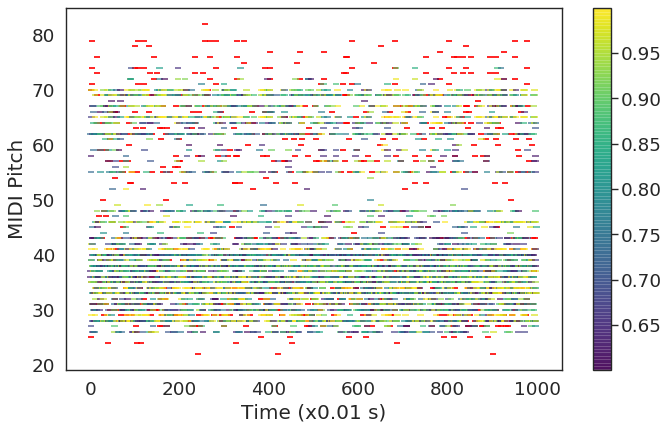

In [160]:
# Labels
val_labels_plt = np.argwhere(val_labels > 0)

# Predictions
val_preds_plt = np.argwhere(val_preds > 0)
val_preds_plt_indices = np.where(val_preds > 0)
val_preds_colors = val_preds_probs[val_preds_plt_indices]

# size_val = val_labels_plt.shape[0]
end_index = 1000
val_labels_end_index = 0
val_preds_end_index = 0

while val_labels_plt[val_labels_end_index,0] < end_index: 
    val_labels_end_index += 1
    
while val_preds_plt[val_preds_end_index,0] < end_index: 
    val_preds_end_index += 1

# Plot
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(val_labels_plt[0:val_labels_end_index,0], val_labels_plt[0:val_labels_end_index,1], marker='_', color='r')
plt.scatter(val_preds_plt[0:val_preds_end_index,0],  val_preds_plt[0:val_preds_end_index,1], marker='_', c=val_preds_colors[0:val_preds_end_index], cmap="viridis", alpha=0.75)
plt.colorbar()
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
# plt.ylim(top=384)
plt.show()



### TEST DATA

In [121]:
PLAYING_THRESH = 0.6

num_notes = 128

test_labels = np.zeros((len(testloader.dataset), num_notes))

sigmoid = torch.nn.Sigmoid()

with torch.no_grad():
    idx = 0
    for data in testloader:
        inputs, labels = data
        test_labels[idx:idx+labels.shape[0], :] = labels.cpu().numpy()
        idx = idx + labels.shape[0]

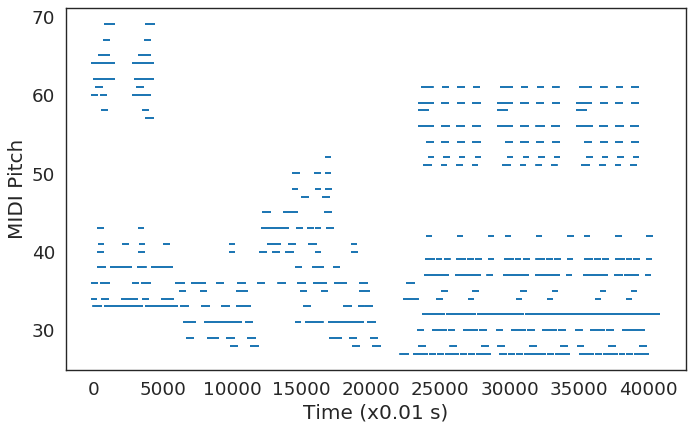

In [125]:
test_labels_plt = np.argwhere(test_labels > 0)

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(test_labels_plt[:,0], test_labels_plt[:,1], marker='_')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
# plt.ylim(top=384)
plt.show()


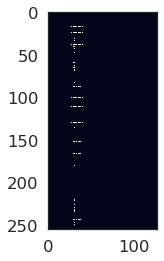

In [155]:
plt.imshow(outputs_np)

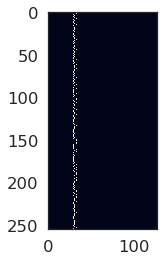

In [156]:
plt.imshow(labels)